# Topic Modelling

## Dependencies

In [1]:
import pandas as pd
import string
import warnings, re
warnings.simplefilter('ignore')
from itertools import chain

import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models
from gensim.parsing.preprocessing import strip_non_alphanum
from gensim.models.coherencemodel import CoherenceModel 


import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


import pyLDAvis
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Patil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Patil\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Patil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
d:\binghamton\semester1\IS2 502\topicmodeling\env\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [2]:
data = pd.read_excel('metoo_tweets_dec2017.xlsx')
data.head()

,column_a,text,favorited,favoritecount,replytosn,created,truncated,replytosid,id,replytouid,statussource,screenname,retweetcount,isretweet,retweeted,longitude,latitude,location
0,1,American Harem.. #MeToo https://t.co/HjExLJdGuF,0.0,0,NaN,2017-11-29T23:59:00,0.0,NaN,9.360000e+17,NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",ahmediaTV,0.0,0.0,0.0,NaN,NaN,NaN
1,2,@johnconyersjr @alfranken why have you guys ...,0.0,0,johnconyersjr,2017-11-29T23:59:00,0.0,NaN,9.360000e+17,266149840,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",JesusPrepper74,0.0,0.0,0.0,NaN,NaN,NaN
2,3,Watched Megan Kelly ask Joe Keery this A.M. if...,0.0,0,NaN,2017-11-29T23:59:00,1.0,NaN,9.360000e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",DemerisePotvin,0.0,0.0,0.0,NaN,NaN,NaN
3,4,Women have been talking about this crap the en...,0.0,0,NaN,2017-11-29T23:59:00,0.0,NaN,9.360000e+17,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",TheDawnStott,0.0,0.0,0.0,NaN,NaN,NaN
4,5,.@BetteMidler please speak to this sexual assa...,0.0,15,NaN,2017-11-29T23:59:00,0.0,NaN,9.360000e+17,NaN,"<a href=""http://twitter.com/#!/download/ipad"" ...",scottygirl2014,11.0,0.0,0.0,NaN,NaN,NaN


In [3]:
filtered_data = data.filter(['text'], axis=1)
filtered_data.head()
filtered_data = filtered_data[filtered_data["text"].apply(lambda x: type(x) == str)]

No of Retweets in dataset: 227060
No of Orginal tweets in dataset: 166056


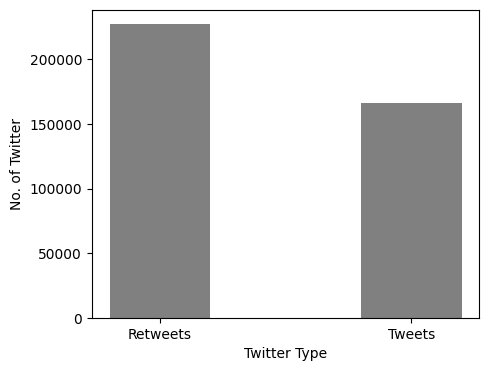

In [4]:
retweets = 0
tweets = 0
for val in filtered_data['text']:
  if 'RT' in val:
    retweets += 1
    continue
  tweets += 1

print(f"No of Retweets in dataset: {retweets}")
print(f"No of Orginal tweets in dataset: {tweets}")


data = {'Retweets':retweets, 'Tweets':tweets }
twitters = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (5, 4))
 
# creating the bar plot
plt.bar(twitters, values, color ='grey',
        width = 0.4)
 
plt.xlabel("Twitter Type")
plt.ylabel("No. of Twitter")
plt.show()

In [5]:
# Removing the false and nanvalues
stop_words = set(stopwords.words('english'))
stop_words  |= set(['ï¿½ï¿½', 'ï¿½', 'x000d', 'rcc', 'mex000d', 'leaguex000daccording', 'jr', 'donohue', 15, 1, 200, 'x000dx000d', 'im', 'u'])

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'ï¿½', '', text)
    text = text.lower()
    text = re.sub("#[A-Za-z0-9_]+","", text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = strip_non_alphanum(text)
    text =  ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word.lower() not in stop_words])
    return text

filtered_data['clean_text'] = filtered_data['text'].apply(clean_text)
filtered_data['clean_tokens'] = filtered_data['clean_text'].apply(lambda x: x.split())

In [6]:
filtered_data.head()

,text,clean_text,clean_tokens
0,American Harem.. #MeToo https://t.co/HjExLJdGuF,american harem,"[american, harem]"
1,@johnconyersjr @alfranken why have you guys ...,guy resigned yet liberal hypocrisy,"[guy, resigned, yet, liberal, hypocrisy]"
2,Watched Megan Kelly ask Joe Keery this A.M. if...,watched megan kelly ask joe keery rub finger h...,"[watched, megan, kelly, ask, joe, keery, rub, ..."
3,Women have been talking about this crap the en...,woman talking crap entire time finally someone...,"[woman, talking, crap, entire, time, finally, ..."
4,.@BetteMidler please speak to this sexual assa...,please speak sexual assault interview,"[please, speak, sexual, assault, interview]"


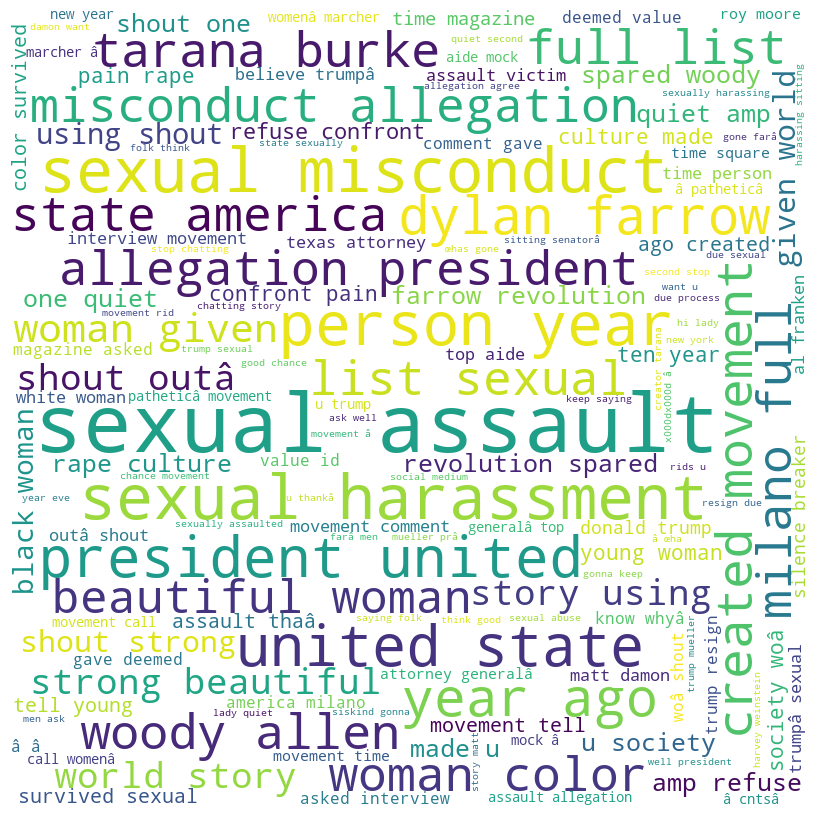

In [8]:
warnings.simplefilter('ignore')




comment_words = ''
counter = {}
for val in filtered_data['clean_tokens']:

    tokens = val
     
    for i in range(len(tokens)):

      tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [11]:
# # Instantiate LDA model
LDA = gensim.models.ldamodel.LdaModel

df = filtered_data[0: 1000]
# df = filtered_data


# create dictionary'
dictionary = corpora.Dictionary(df['clean_tokens'])

# Total number of non-zeroes in the BOW matrix (sum of the number of unique words per document over the entire corpus).
# print(dictionary.token2id)


# # Create document term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df['clean_tokens'] ]
# print(doc_term_matrix)


num_topics= 10
ldamodel = LDA(doc_term_matrix, num_topics=num_topics, id2word=dictionary, alpha='asymmetric', passes=100, minimum_probability=1e-8)
ldamodel.print_topics(num_topics)


model_filename = "model"
ldamodel.save(model_filename)



In [12]:
# Load a potentially pretrained model from disk.
_ldamodel = LDA.load(model_filename)

# # Visualize the LDA model results

# lda_display = pyLDAvis.gensim_models.prepare(_ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
lda_display = pyLDAvis.gensim_models.prepare(_ldamodel, doc_term_matrix, dictionary,  mds = 'pcoa')

pyLDAvis.display(lda_display)


In [13]:
print('\nPerplexity: ', _ldamodel.log_perplexity(doc_term_matrix, total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=_ldamodel, texts=df['clean_tokens'], dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.276215564816425

Coherence Score:  0.4390669617901978


In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus= doc_term_matrix, texts= df['clean_tokens'], limit=50, start=2, step=1)

print(model_list, coherence_values)

[<gensim.models.ldamodel.LdaModel object at 0x000001B6ED96C580>, <gensim.models.ldamodel.LdaModel object at 0x000001B6BE5B7FA0>, <gensim.models.ldamodel.LdaModel object at 0x000001B68B7DE800>, <gensim.models.ldamodel.LdaModel object at 0x000001B6BE5B47C0>, <gensim.models.ldamodel.LdaModel object at 0x000001B6DE6907C0>, <gensim.models.ldamodel.LdaModel object at 0x000001B6DE6638E0>, <gensim.models.ldamodel.LdaModel object at 0x000001B6DE677A90>, <gensim.models.ldamodel.LdaModel object at 0x000001B6DE6FAD40>, <gensim.models.ldamodel.LdaModel object at 0x000001B6DE6F9C00>, <gensim.models.ldamodel.LdaModel object at 0x000001B68B7C1540>, <gensim.models.ldamodel.LdaModel object at 0x000001B6DE704EE0>, <gensim.models.ldamodel.LdaModel object at 0x000001B6DE707AC0>, <gensim.models.ldamodel.LdaModel object at 0x000001B68166BDC0>, <gensim.models.ldamodel.LdaModel object at 0x000001B68166A980>, <gensim.models.ldamodel.LdaModel object at 0x000001B6C57AA1A0>, <gensim.models.ldamodel.LdaModel object

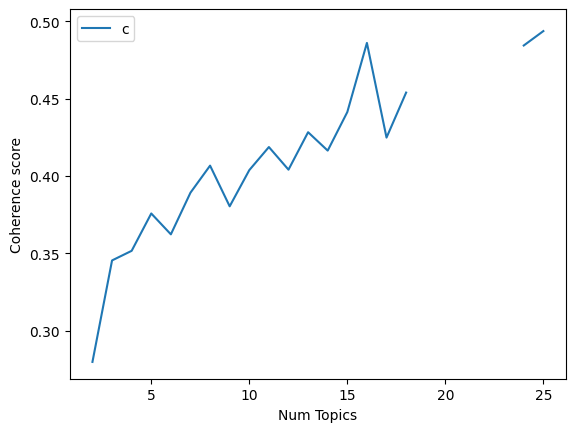

In [22]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [18]:
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 0.6 # Adjust this accordingly based on tuning above
for i in range(1, num_topics): #Adjust this to reflect number of topics chosen for final LDA model
    topic = lda_display.topic_info[lda_display.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [19]:
pd.DataFrame(all_topics).T

,0,1,2,3,4,5,6,7,8,9
Topic 1,woman,lauer,matt,moment,harassment,moron,many,sexual,donald,diminishing
Topic 2,im,need,going,woman,year,keillor,someone,sexual,garrison,men
Topic 3,president,tweet,gleeful,accused,movement,accuser,say,trump,dangerous,one
Topic 4,military,woman,member,button,lock,office,u,word,abuse,desk
Topic 5,matter,woman,hard,power,position,pig,men,yeah,geraldo,employee
Topic 6,misconduct,sexual,hold,like,usually,there,gay,resist,jewish,stathe
Topic 7,amp,x000dx000d,oh,defend,go,theyre,young,didnt,undercover,british
Topic 8,go,problem,say,deny,united,get,courage,flirty,act,took
Topic 9,title,real,era,school,one,lewinsky,special,hln,forgotten,snowball
